In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!pip install pulp
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
from scipy.spatial import distance_matrix
from pulp import LpMaximize, LpProblem, LpVariable, lpSum
import geopandas as gpd
from shapely.geometry import Point
import folium

Mounted at /content/gdrive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 81.6 MB/s eta 0:00:00


In [2]:
# ================================
# 1. 데이터 불러오기 및 전처리
# ================================
# 파일 경로 설정 및 데이터 읽기
file_path = "/content/gdrive/MyDrive/co-data/FINAL_BLOOD_RELEASE_2023.csv"
df = pd.read_csv(file_path)

# 출고일자 형식 변환 및 2023년 데이터 필터링
df['출고일자'] = pd.to_datetime(df['출고일자'])
df = df[df['출고일자'].dt.year == 2023]

# 병원별 출고 빈도 및 중요도 계산
df['출고빈도'] = df.groupby('기관명')['출고일자'].transform('nunique')  # 병원이 출고한 날짜 수
df['중요도'] = df['출고건수'] * (1 + np.log1p(df['출고빈도']))  # 출고건수와 빈도 기반 가중치

# 병원 위치와 수요(중요도) 변수 설정
hospital_coords = df[['병원경도', '병원위도']].values
hospital_demand = df['중요도'].values

In [3]:
# ================================
# 2. 후보지(격자) 생성
# ================================
# 격자 간격 설정 (도 단위)
grid_size = 0.0045

# 병원 위치 범위를 기준으로 격자 경계 설정
min_lat, max_lat = df["병원위도"].min(), df["병원위도"].max()
min_lon, max_lon = df["병원경도"].min(), df["병원경도"].max()

# 위도, 경도 격자 생성
lat_grid = np.arange(min_lat, max_lat, grid_size)
lon_grid = np.arange(min_lon, max_lon, grid_size)

# 각 격자점을 Point 객체로 생성
grid_points = [Point(lon, lat) for lat in lat_grid for lon in lon_grid]

# GeoDataFrame 생성 및 좌표 컬럼 추가
grid_df = gpd.GeoDataFrame({'geometry': grid_points}, crs="EPSG:4326")
grid_df['lon'] = grid_df.geometry.x
grid_df['lat'] = grid_df.geometry.y

In [4]:
# ================================
# 3. KDE (커널 밀도 추정) 계산
# ================================
# 병원 좌표를 2행 배열 (x: 경도, y: 위도)로 준비
xy = np.vstack([hospital_coords[:, 0], hospital_coords[:, 1]])

# 병원 수요(중요도)를 가중치로 하여 KDE 계산
kde = gaussian_kde(xy, weights=hospital_demand)
kde_values = kde(np.vstack([grid_df['lon'], grid_df['lat']]))
grid_df['KDE'] = kde_values

# KDE 값 정규화 (0~1 범위)
grid_df['KDE_norm'] = (grid_df['KDE'] - grid_df['KDE'].min()) / (grid_df['KDE'].max() - grid_df['KDE'].min())


In [5]:
# ================================
# 4. 거리 행렬 및 커버리지 계산
# ================================
# 후보지(격자) 좌표 배열 생성
grid_coords = np.array([(pt.x, pt.y) for pt in grid_df.geometry])

# 각 후보지와 병원 사이의 거리 행렬 계산
dist_mat = distance_matrix(grid_coords, hospital_coords)

# 지정 반경(예: 0.02도) 이내이면 해당 병원을 커버한다고 가정
coverage_radius = 0.02
coverage = (dist_mat < coverage_radius).astype(int)

# 전체 병원 수요(중요도)를 100% 커버하는 제약 조건 (여기서는 비율 1.0)
min_coverage_ratio = 1.0

In [7]:
# ================================
# 5. 최적화 모델 구성 (KDE 반영)
# ================================
model = LpProblem("KDE_Weighted_Facility_Location", LpMaximize)

# 후보지 선택 변수: x[i] = 1이면 후보지 i 선택
x = {i: LpVariable(f"x_{i}", cat="Binary") for i in range(len(grid_df))}

# 병원 커버리지 변수: z[j] = 1이면 병원 j가 후보지에 의해 커버됨
z = {j: LpVariable(f"z_{j}", cat="Binary") for j in range(len(hospital_coords))}

# 목적 함수: 후보지의 정규화된 KDE 값을 최대화 (수요 밀도가 높은 곳 우선 선택)
model += lpSum(x[i] * grid_df.loc[i, 'KDE_norm'] for i in range(len(grid_df)))

# 제약 조건 1: 각 병원은 적어도 하나의 후보지에 의해 커버되어야 함
for j in range(len(hospital_coords)):
    model += lpSum(x[i] * coverage[i, j] for i in range(len(grid_df))) >= z[j]

# 제약 조건 2: 전체 병원 수요(중요도)의 최소 100%가 커버되어야 함
model += lpSum(z[j] * hospital_demand[j] for j in range(len(hospital_coords))) >= min_coverage_ratio * sum(hospital_demand)

# 최적화 실행
model.solve()

# 선택된 후보지 인덱스 도출
optimal_indices = [i for i in range(len(grid_df)) if x[i].varValue == 1]
grid_df['Selected'] = 0
grid_df.loc[optimal_indices, 'Selected'] = 1


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from scipy.stats import gaussian_kde
from scipy.spatial import distance_matrix
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

In [ ]:
# ================================
# 6. 결과 시각화
# ================================

import geopandas as gpd
import folium

# 행정동 경계 불러오기
seoul_geo_path = '/content/gdrive/MyDrive/co-data/서울_행정동_경계_2017.geojson'
seoul_gdf = gpd.read_file(seoul_geo_path).to_crs(epsg=4326)

# 지도 중심 설정
map_center = [df["병원위도"].mean(), df["병원경도"].mean()]
target_map = folium.Map(location=map_center, zoom_start=12, tiles='cartodbpositron')

# 1. 서울시 경계 (행정동)
folium.GeoJson(
    seoul_gdf,
    name='서울시 행정동 경계',
    style_function=lambda feature: {
        'fillColor': 'lightgray',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.1,
    }
).add_to(target_map)

# 2. 병원 위치 (빨간 원, 출고건수 팝업)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row["병원위도"], row["병원경도"]],
        radius=5,
        color="red",
        fill=True,
        fill_opacity=0.6,
        popup=f"{row['기관명']}<br>출고건수: {row['출고건수']}"
    ).add_to(target_map)

# 3. KDE 기반 후보지 시각화
for _, row in grid_df.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=row["KDE_norm"] * 10,
        color="green" if row.get('Selected', 0) == 1 else "blue",
        fill=True,
        fill_opacity=0.9 if row.get('Selected', 0) == 1 else 0.3,
        popup=f"KDE: {row['KDE']:.4e}"
    ).add_to(target_map)

In [ ]:
selected_count = grid_df['Selected'].sum()
print(f"✅ 최적화로 선택된 후보지 개수: {int(selected_count)}개")

✅ 최적화로 선택된 후보지 개수: 4038개


In [ ]:
# ================================
# 6. 저장
# ================================

target_map.save("/content/gdrive/MyDrive/co-data/CANDIDATED_MAP.html")

# 결과 파일 저장 (선택된 후보지 포함)
output_df = grid_df.copy()
output_df["경도"] = grid_df.geometry.x
output_df["위도"] = grid_df.geometry.y
output_df["Optimal"] = grid_df["Selected"]  # 컬럼명 통일

output_df[['경도', '위도', 'KDE', 'KDE_norm', 'Optimal']].to_csv(
    "/content/gdrive/MyDrive/co-data/CANDIDATED_RESULTS_OPTIMIZED.csv",
    index=False,
    encoding="utf-8-sig"
)

print("✅ 지도 저장 완료: CANDIDATED_MAP.html")
print("✅ 선택된 후보지 데이터 저장 완료: CANDIDATED_RESULTS_OPTIMIZED.csv")

✅ 지도 저장 완료: CANDIDATED_MAP.html
✅ 선택된 후보지 데이터 저장 완료: CANDIDATED_RESULTS_OPTIMIZED.csv


### 서울시매핑, 한강 지우기

<ipython-input-10-db549c6ce4a0>:30: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  han_river_polygon = han_river_gdf.geometry.buffer(buffer_size).unary_union
<ipython-input-10-db549c6ce4a0>:30: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  han_river_polygon = han_river_gdf.geometry.buffer(buffer_size).unary_union


✅ 한강 내부 후보지 제거 완료
✅ 서울시 내부 후보지만 필터링 완료


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loca

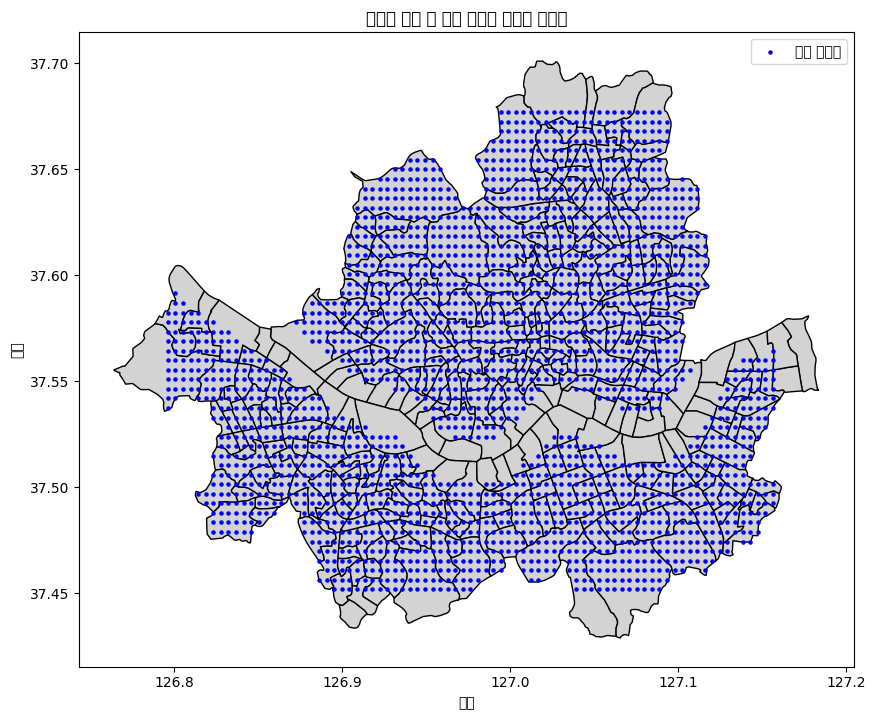

In [10]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# -------------------------
# 1. 후보지 데이터 로드
# -------------------------
df = pd.read_csv('/content/gdrive/MyDrive/co-data/CANDIDATED_RESULTS_OPTIMIZED.csv')

# GeoDataFrame 변환
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['경도'], df['위도']), crs="EPSG:4326")

# -------------------------
# 2. 서울시 행정동 GeoJSON 불러오기
# -------------------------
seoul_path = "/content/gdrive/MyDrive/co-data/서울_행정동_경계_2017.geojson"
seoul_gdf = gpd.read_file(seoul_path)
seoul_gdf = seoul_gdf.rename(columns={"adm_nm": "행정동"})
seoul_gdf = seoul_gdf.set_crs(epsg=4326)

# -------------------------
# 3. 한강 경계 불러오기 및 Polygon 처리
# -------------------------
han_river_path = "/content/gdrive/MyDrive/co-data/han_river (1).geojson"
han_river_gdf = gpd.read_file(han_river_path)
han_river_gdf = han_river_gdf.to_crs(epsg=4326)

if han_river_gdf.geometry.iloc[0].geom_type == "LineString":
    buffer_size = 0.01  # 약 1km
    han_river_polygon = han_river_gdf.geometry.buffer(buffer_size).unary_union
else:
    han_river_polygon = han_river_gdf.unary_union

# -------------------------
# 4. 한강 영역 제외 (within)
# -------------------------
gdf["before_hangang"] = gdf["Optimal"]
gdf.loc[gdf.geometry.within(han_river_polygon), "Optimal"] = 0
print("✅ 한강 내부 후보지 제거 완료")

# -------------------------
# 5. 서울시 내부 필터링 (within)
# -------------------------
gdf = gpd.sjoin(gdf, seoul_gdf, how="inner", predicate="within")
print("✅ 서울시 내부 후보지만 필터링 완료")

# -------------------------
# 6. 시각화 (선택)
# -------------------------
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))
seoul_gdf.plot(ax=ax, color='lightgray', edgecolor='black')

gdf[gdf["Optimal"] == 1].plot(ax=ax, color='blue', markersize=5, label="유효 후보지")
plt.legend()
plt.title("서울시 경계 및 한강 필터링 완료된 후보지")
plt.xlabel("경도")
plt.ylabel("위도")
plt.show()

In [11]:
print("✅ 최종 유효 후보지 개수:", gdf[gdf["Optimal"] == 1].shape[0])


✅ 최종 유효 후보지 개수: 2503


In [12]:
gdf.to_csv('/content/gdrive/MyDrive/co-data/CANDIDATED_RESULTS_OPTIMIZED.csv', index=False, encoding='utf-8-sig')
print("✅ 파일이 저장되었습니다: CANDIDATED_RESULTS_OPTIMIZED.csv")


✅ 파일이 저장되었습니다: CANDIDATED_RESULTS_OPTIMIZED.csv
